# Iris Model Eval
Sara Echeverría 21371

## Part I

### Task 1

In [13]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

In [14]:
# Load the dataset
iris = load_iris()
xData = iris.data
yData = iris.target

# scale the data
scaler = StandardScaler()
xData = scaler.fit_transform(xData)

# use tensor datatype and split into training and validation sets
xData = torch.tensor(xData, dtype=torch.float32)
yData = torch.tensor(yData, dtype=torch.long)

xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.3, random_state=42)

# convert to tensor dataset and create data loaders
trainDataset = TensorDataset(xTrain, yTrain)
valDataset = TensorDataset(xVal, yVal)
trainLoader = DataLoader(trainDataset, batch_size=16, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=16)

### Task 2

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize, dropoutRate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.bn1 = nn.BatchNorm1d(hiddenSize)
        self.fc2 = nn.Linear(hiddenSize, hiddenSize)
        self.bn2 = nn.BatchNorm1d(hiddenSize)
        self.fc3 = nn.Linear(hiddenSize, outputSize)
        self.dropout = nn.Dropout(dropoutRate)

    def forward(self, x):
        # leakyReLU activation and batch normalization
        out = F.leaky_relu(self.bn1(self.fc1(x)))  
        
        # dropout after first hidden layer
        out = self.dropout(out)  
        
        # leakyReLU activation and batch normalization
        out = F.leaky_relu(self.bn2(self.fc2(out))) 
        
        # dropout after second hidden layer 
        out = self.dropout(out)  
        out = self.fc3(out)
        return out

In [16]:
# initialize the model
model = SimpleNN(inputSize=4, hiddenSize=10, outputSize=3)

### Tasks 3, 4 & 5

In [17]:
# Loss functions
criterionCe = nn.CrossEntropyLoss()
criterionMse = nn.MSELoss()
criterionNll = nn.NLLLoss()

# optimizer and regularization
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# l2
optimizerL2 = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# l1
def l1Penalty(model, l1Lambda):
    l1Norm = sum(p.abs().sum() for p in model.parameters())
    return l1Lambda * l1Norm

In [18]:
class ModifiedSimpleNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize, dropoutRate=0.5):
        super(ModifiedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.bn1 = nn.BatchNorm1d(hiddenSize)
        self.fc2 = nn.Linear(hiddenSize, hiddenSize)
        self.bn2 = nn.BatchNorm1d(hiddenSize)
        self.fc3 = nn.Linear(hiddenSize, outputSize)
        self.dropout = nn.Dropout(dropoutRate)

    def forward(self, x):
        # leakyReLU activation and batch normalization
        x = F.leaky_relu(self.bn1(self.fc1(x)))  
        
        # dropout after first hidden layer
        x = self.dropout(x) 
        
        # leakyReLU activation and batch normalization
        x = F.leaky_relu(self.bn2(self.fc2(x))) 
        
        # dropout after second hidden layer
        x = self.dropout(x)  
        x = self.fc3(x)
        return x

In [19]:
# initialize the model
modelDropout = ModifiedSimpleNN(inputSize=4, hiddenSize=10, outputSize=3)

In [20]:
# adam
optimizerAdam = torch.optim.Adam(model.parameters(), lr=0.01)

# sgd
optimizerSgd = torch.optim.SGD(model.parameters(), lr=0.01)

In [21]:
def trainModel(model, trainLoader, valLoader, criterion, optimizer, epochs=50):
    trainLosses = []
    valLosses = []
    accuracy = []

    for epoch in range(epochs):
        model.train()
        runningLoss = 0.0
        for inputs, labels in trainLoader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # convert labels to one-hot encoding if using MSELoss
            if isinstance(criterion, nn.MSELoss):
                labels = F.one_hot(labels, num_classes=outputs.size(1)).float()
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()

        trainLosses.append(runningLoss / len(trainLoader))

        model.eval()
        valLoss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in valLoader:
                outputs = model(inputs)
                
                # convert labels to one-hot encoding if using MSELoss
                if isinstance(criterion, nn.MSELoss):
                    labels = F.one_hot(labels, num_classes=outputs.size(1)).float()
                
                loss = criterion(outputs, labels)
                valLoss += loss.item()
                _, predicted = torch.max(outputs, 1)
                
                # apply argmax according to the dimension of the labels
                if labels.dim() > 1:
                    correct += (predicted == labels.argmax(1)).sum().item()
                else:
                    correct += (predicted == labels).sum().item()
                
                total += labels.size(0)

        valLosses.append(valLoss / len(valLoader))
        accuracy.append(100 * correct / total)

    return trainLosses, valLosses, accuracy

### Task 6

In [22]:
# get the combinations of loss functions, optimizers, and regularization
def getCombinations():
    yield {"lossFn": nn.CrossEntropyLoss(), "optimizer": optim.Adam, "regularization": "L2", "name": "crossentropy + adam + l2"}
    yield {"lossFn": nn.CrossEntropyLoss(), "optimizer": optim.SGD, "regularization": "L2", "name": "crossentropy + sgd + l2"}
    yield {"lossFn": nn.CrossEntropyLoss(), "optimizer": optim.SGD, "regularization": "L1", "name": "crossentropy + sgd + l1"}
    yield {"lossFn": nn.CrossEntropyLoss(), "optimizer": optim.Adam, "regularization": None, "name": "crossentropy + adam"}
    yield {"lossFn": nn.CrossEntropyLoss(), "optimizer": optim.SGD, "regularization": None, "name": "crossentropy + sgd"}
    yield {"lossFn": nn.NLLLoss(), "optimizer": optim.Adam, "regularization": "Dropout", "name": "nll + adam + dropout"}
    yield {"lossFn": nn.MSELoss(), "optimizer": optim.SGD, "regularization": "Dropout", "name": "mse + sgd + dropout"}
    yield {"lossFn": nn.MSELoss(), "optimizer": optim.Adam, "regularization": None, "name": "mse + adam"}
    yield {"lossFn": nn.NLLLoss(), "optimizer": optim.SGD, "regularization": None, "name": "nll + sgd"}

results = {}

In [23]:
# iterate over the combinations
for config in getCombinations():
    model = SimpleNN(inputSize=4, hiddenSize=10, outputSize=3)
    
    if config["regularization"] == "L2":
        optimizer = config["optimizer"](model.parameters(), lr=0.01, weight_decay=0.01)
    elif config["regularization"] == "L1":
        optimizer = config["optimizer"](model.parameters(), lr=0.01)
    elif config["regularization"] == "Dropout":
        model = ModifiedSimpleNN(inputSize=4, hiddenSize=10, outputSize=3)
        optimizer = config["optimizer"](model.parameters(), lr=0.01)
    else:
        optimizer = config["optimizer"](model.parameters(), lr=0.01)
    
    # training
    trainLosses, valLosses, accuracy = trainModel(model, trainLoader, valLoader, config["lossFn"], optimizer)
    
    # save results
    results[config["name"]] = (trainLosses, valLosses, accuracy)

<Figure size 1400x500 with 0 Axes>

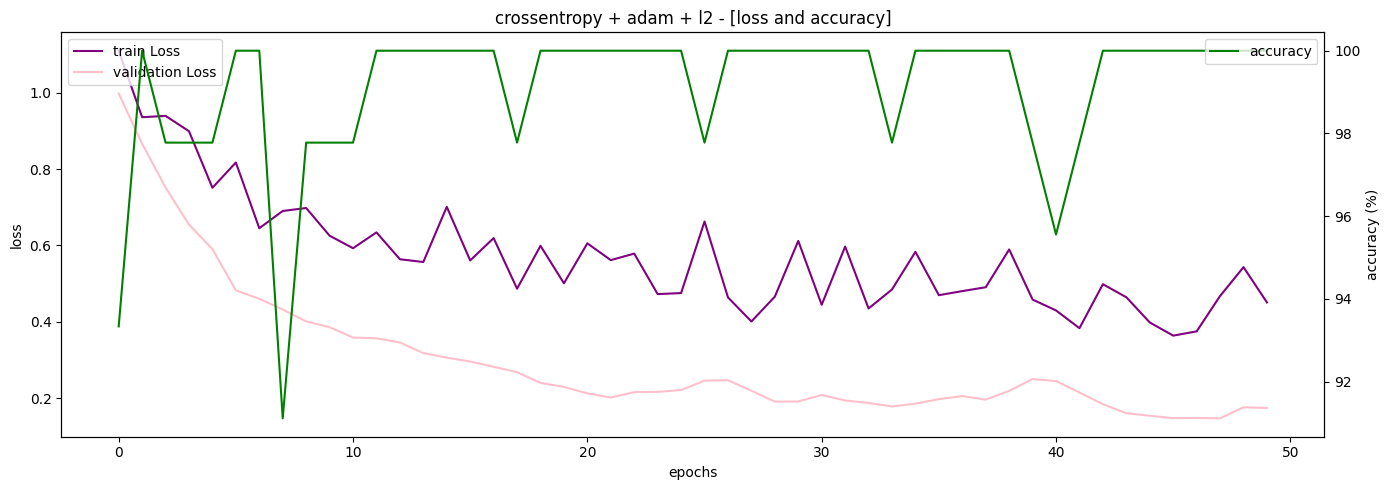

<Figure size 1400x500 with 0 Axes>

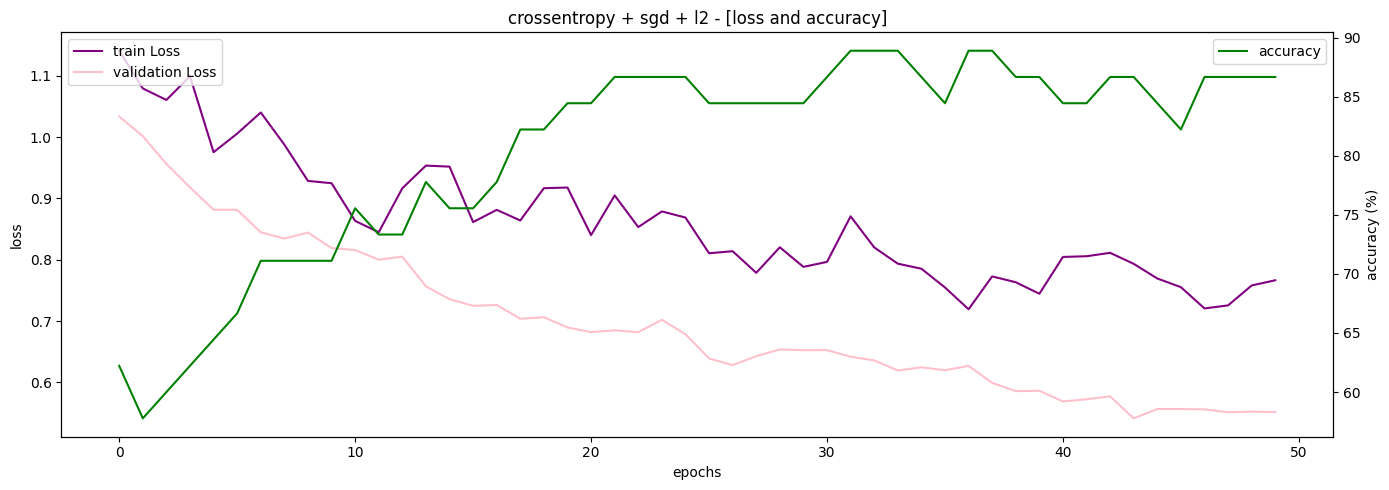

<Figure size 1400x500 with 0 Axes>

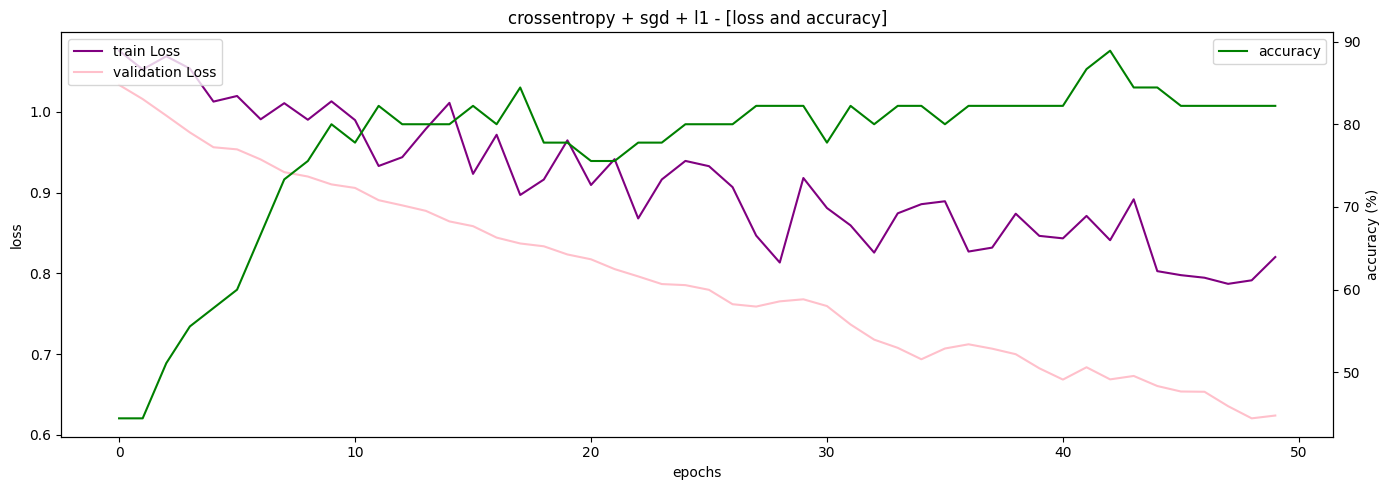

<Figure size 1400x500 with 0 Axes>

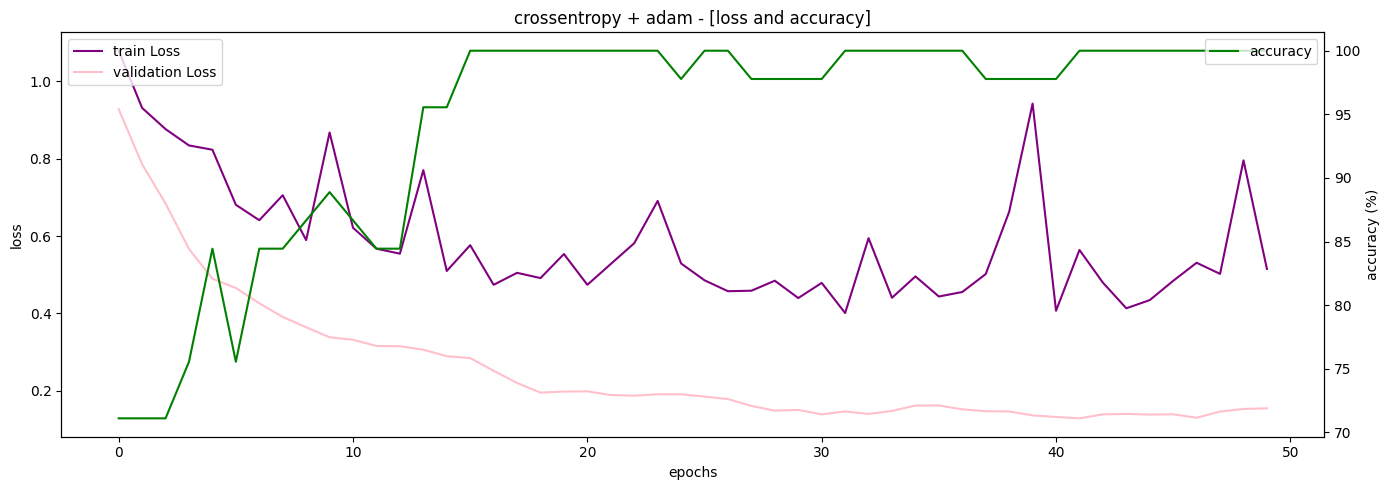

<Figure size 1400x500 with 0 Axes>

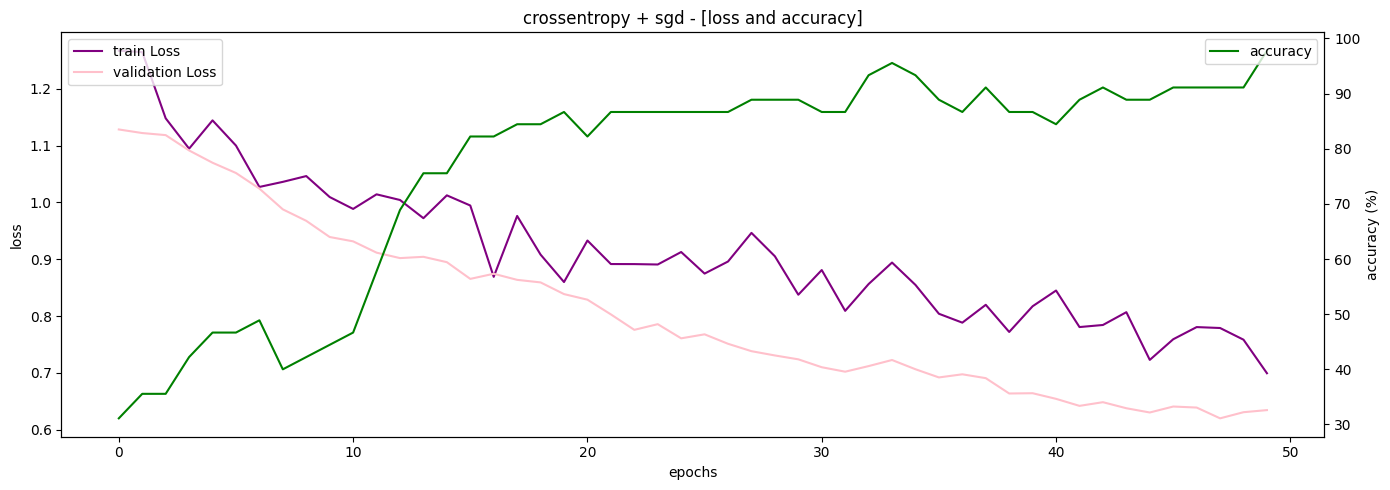

<Figure size 1400x500 with 0 Axes>

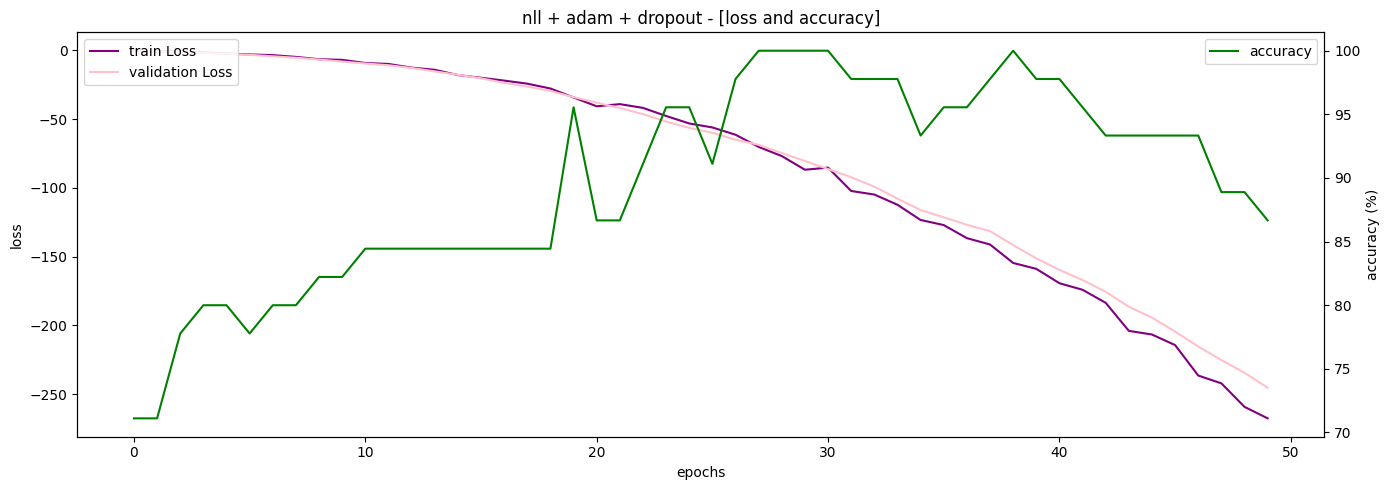

<Figure size 1400x500 with 0 Axes>

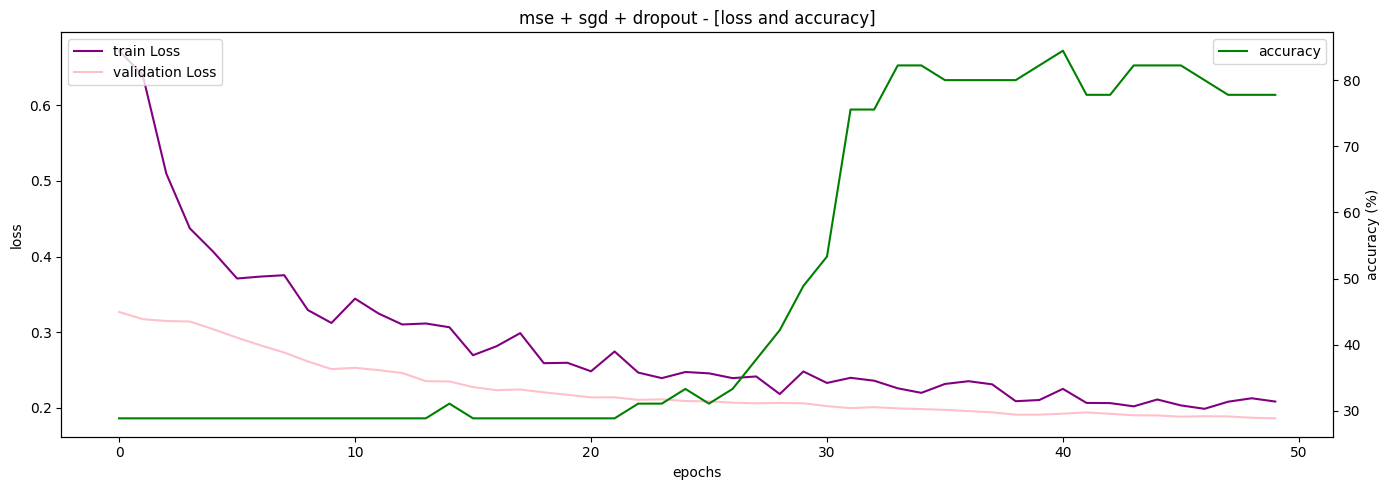

<Figure size 1400x500 with 0 Axes>

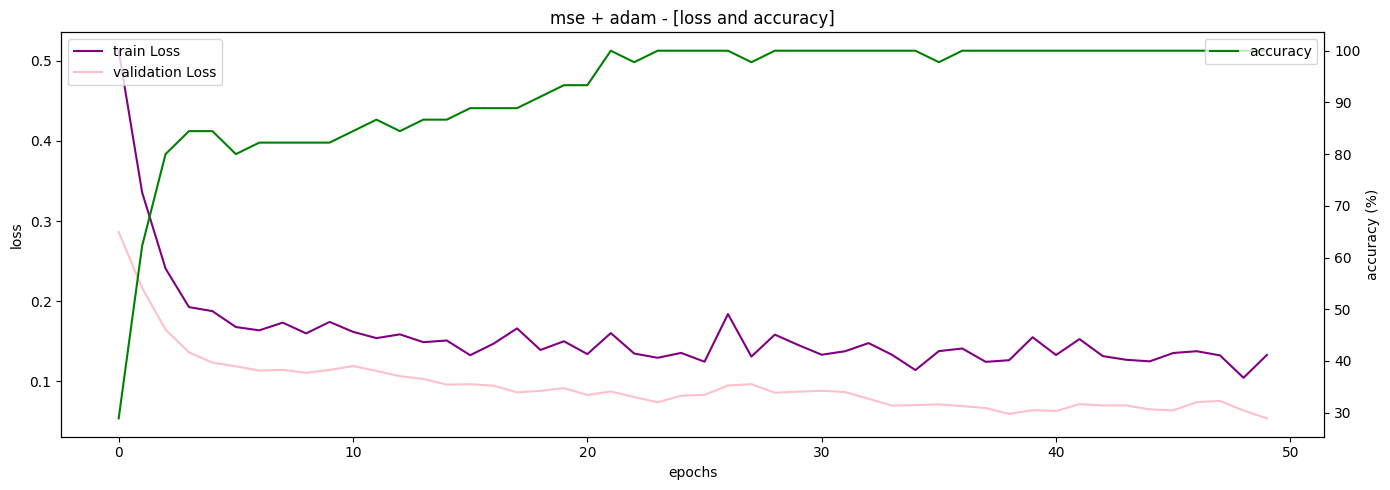

<Figure size 1400x500 with 0 Axes>

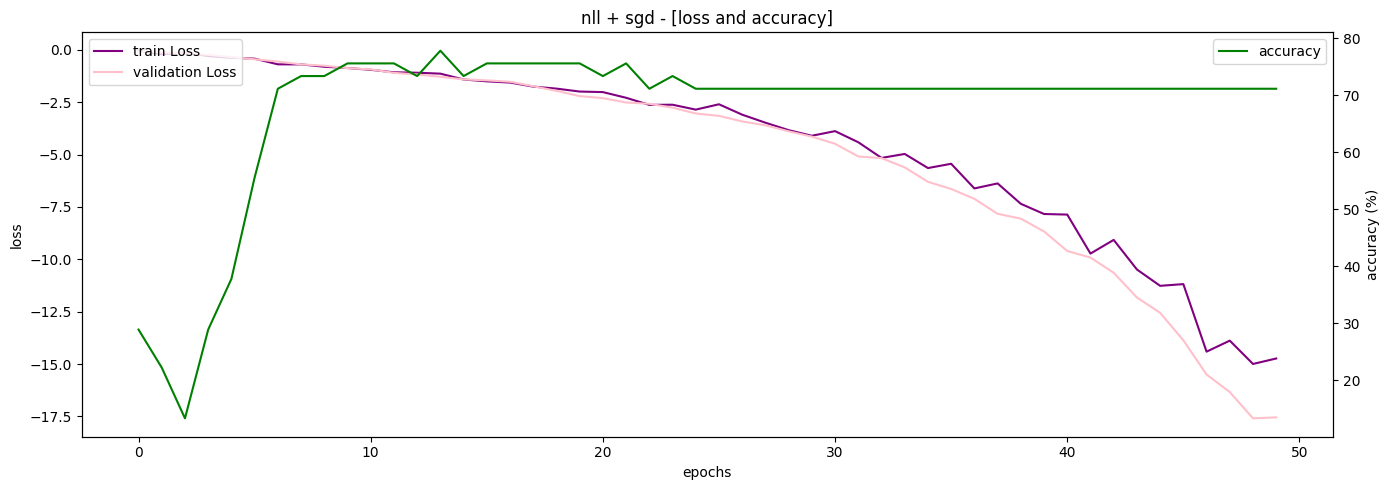

In [24]:
# graphs
for key, (trainLosses, valLosses, accuracy) in results.items():
    plt.figure(figsize=(14, 5))

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.plot(trainLosses, label='train Loss', color='purple')
    ax1.plot(valLosses, label='validation Loss', color='pink')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy (%)')
    ax2.plot(accuracy, label='accuracy', color='green')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')

    plt.title(f'{key} - [loss and accuracy]')
    fig.tight_layout()
    plt.show()

### Task 7